In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Common imports
import fitsio
import numpy as np
import os
import pandas as pd
import sys

In [3]:
# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=18)

In [4]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [6]:
# QuasarNET imports
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, objective
from quasarnet.utils import process_preds, absorber_IGM

In [7]:
# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [9]:
def plot_spectrum(ival,X,c_line,z_line,zbest,Y,z,c_th=0.5,ndetect=1):
    llmin = np.log10(3600)
    llmax = np.log10(10000)
    dll = 1e-3

    nbins = int((llmax-llmin)/dll)
    wave = 10**(llmin + np.arange(nbins)*dll)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(wave, X[ival,:])
    
    isqso_truth = (Y[ival,:].argmax()==2) | (Y[ival,:].argmax()==3)
    isqso_qn = (c_line[:,ival].sum()>c_th)>=ndetect
    
    title = r'Is QSO? VI: {}, QN: {}'.format(isqso_truth,isqso_qn)
    title += '\n'
    title += r'$z_{{VI}}$={:1.3f}, $z_{{QN}}$='.format(z[ival])
    if isqso_qn:
        title += r'{:1.3f}'.format(zbest[ival])
    else:
        title += 'N/A'
    
    ax.set_title(title)
    m = X[ival,:].min()
    M = X[ival,:].max()
    ax.grid()
    ax.set_ylim(m-2,M+2)
    for il,l in enumerate(lines):
        lam = absorber_IGM[l]*(1+z_line[il,ival])
        w = abs(wave-lam)<100
        if w.sum()>0:
            m = X[ival,w].min()-1
            M = X[ival,w].max()+1
            ax.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il,ival])
            ax.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,ival],3)),
                     horizontalalignment='center',alpha=0.1+0.9*c_line[il,ival])
    ax.set_xlabel(r'$\lambda_\mathrm{obs}~[\AA]$')
    ax.set_ylabel(r'renormalised flux')
    plt.show()
    
    return

# Get VI truth table

In [13]:
truth=pd.read_csv('/global/cfs/cdirs/desi/sv/vi/TruthTables/ZZ_ARCHIVE/truth_table_QSO_tile68002_night20200315.csv', sep=',',header=None)
truth

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,TargetID,Redrock z,best z,best class,Redrock spectype,best spectype,best issue,all VI comments,merger comment,N_VI,DELTACHI2,FIBER,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z
1,35185971884459940,1.4427,1.4427,4.0,QSO,QSO,--,--|--|--,none,3,5279.8785065282145,3942,8.637732000000002,9.675535,8.468992,6.7229475999999995,7.530694,6.591613300000001
2,35185971884460074,1.2239,1.2239,4.0,GALAXY,GALAXY,--,--|--|--,none,3,924.1756200790404,3937,0.5747589,0.7450583000000001,1.1287504,0.4468618,0.5792656999999999,0.8775775
3,35185971884461100,1.8538,1.8538,4.0,QSO,QSO,--,BAL 4950 ?|--|--,none,3,50638.69500005245,3805,30.838114,32.18891,40.183144,24.02581,25.078209,31.306475
4,35185971884461350,0.6782,0.6782,4.0,QSO,QSO,--,--|--|--,none,3,12146.61691302061,3617,12.755448,14.359747,13.682804999999998,9.930698,11.179718,10.652688000000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,35185947926594059,1.68,1.68,1.3333333333333333,QSO,QSO,CR-,--|--| Splice error mistaken for Mg II at z=1.68?,none,3,4.233482647687197,638,0.5514775,0.7436751,0.7509278,0.42806005,0.57724494,0.58287454
914,35185947926594063,0.0002,0.0002,2.0,STAR,STAR,--,--|--|--,Absorption on noise spikes,3,13.408076240679293,608,0.8352455,1.5026464,2.0986287999999997,0.6495361999999999,1.1685464,1.6320175
915,35185947926594275,0.6211,0.6211,4.0,GALAXY,GALAXY,--,--|--|--,none,3,342.80523176491266,641,0.6887189,1.3849512,2.8950355,0.5353901,1.0766209,2.2505167
916,35185947926594399,3.0843,3.0843000000000003,4.0,QSO,QSO,--,--|--|--,none,3,5554.262608885765,648,2.5678208,3.5812483,2.8515048,1.9992515,2.7882848,2.2201218999999996


In [14]:
truth.drop([0],axis = 0, inplace=True)

# Get QuasarNET results

In [15]:
from astropy.io import fits
from astropy.table import Table

In [16]:
!parse_data_desisim --spectra /global/cfs/cdirs/desi/spectro/redux/blanc/tiles/68002/20200315/coadd-*-68002-20200315.fits --out QuasarNET_results/blanc-68002-20200315.fits.gz --mode DESI_COADD --desi-period cmx
!qn_export --model /global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/qn_models/main_setup/coadd/prop_0.1/model_indtrain_0_0/qn_train_coadd_indtrain_0_0.h5 --data QuasarNET_results/blanc-68002-20200315.fits.gz --mode DESI_COADD --out-dir QuasarNET_results --out-suffix 68002 --data-training /global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/data/coadd/training_datasets/prop_0.1/data_dr12_coadd_train_indtrain_0_0.fits 

/bin/bash: parse_data_desisim: command not found
/bin/bash: qn_export: command not found


In [19]:
results = fits.open('QuasarNET_results/qnAll-68002.fits')
results.info()

Filename: QuasarNET_results/qnAll-68002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     31   489R x 11C   [K, 8A, J, J, D, K, K, 6D, 6D, 1D, 1D]   


In [20]:
restab = Table(results[1].data)
restab[:5]

TARGETID,BRICKNAME,BRICK_OBJID,FIBER,ZBEST,IS_QSO,IN_TRAIN,C_LINES [6],Z_LINES [6],C_LINES_BAL,Z_LINES_BAL
int64,str8,int32,int32,float64,int64,int64,float64,float64,float64,float64
35185923939370065,2017p067,1105,478,0.1534372256780534,0,0,3.4741726722131716e-06 .. 5.260219768388197e-05,4.769233854448434 .. 0.1534372256780534,5.405112460721284e-06,1.8219731232098835
35185923939371431,2017p067,2471,397,2.137510056476928,1,0,0.9999772906303406 .. 0.00013503432273864746,2.131393627470325 .. 0.35019081272564834,0.0007658898830413818,2.1311314471160134
35185923939373842,2017p067,4882,394,0.5701272240300743,0,0,0.001934736967086792 .. 0.00013932585716247559,2.028133056226005 .. 0.4649107654457434,4.2685396692832e-06,5.343898700888297
35185923943563502,2019p067,238,470,0.9764205340347498,0,0,4.8979978600982577e-05 .. 8.55374128150288e-06,4.6575773520294845 .. 0.3542256177993566,1.8636874301591888e-05,2.8349375550811793
35185923943564249,2019p067,985,459,1.8132173158497569,0,0,8.176068149623461e-06 .. 2.5507328246021643e-05,3.9384595541637504 .. 0.20826669394629183,1.1492180647110217e-06,4.11068275656167


In [21]:
restab['TARGETID'].shape

(489,)

# Define the testing catalogue

In [22]:
w = [classi==1 for classi in restab['IS_QSO']]
restab = restab[w]

# Apply the truth information to the QuasarNET result (TargetID,redshift,classification)

In [23]:
TargetID_VI = []
z_VI = []
classification_VI = []
for tar_id,z,classification in zip(truth[0],truth[2],truth[5]):
    if np.int64(tar_id) in restab['TARGETID']:
        TargetID_VI.append(np.int64(tar_id))
        z_VI.append(float(z))
        if classification == 'QSO':
            if float(z) >= 2.1:
                classification_VI.append([0,0,0,1,0])
            elif float(z) < 2.1:
                classification_VI.append([0,0,1,0,0])
        elif classification == 'STAR':
            classification_VI.append([1,0,0,0,0])
        elif classification == 'GALAXY':
            classification_VI.append([0,1,0,0,0])
        else:
            classification_VI.append([0,0,0,0,1])
TargetID_VI = np.array(TargetID_VI)
z_VI = np.array(z_VI)
classification_VI = np.array(classification_VI)

w = [tar in TargetID_VI for tar in restab['TARGETID']]
restab = restab[w]

# Get spectra for visualisation

In [25]:
spectra = fitsio.FITS('/global/u1/t/tanting/Machine_Learning_quasar/QuasarNET/QuasarNET_results/blanc-68002-20200315.fits.gz')
Spectra = []
for i,tar_id in enumerate(spectra[1]['TARGETID'][:]):
    if tar_id in TargetID_VI:
        Spectra.append(spectra[0][i,:443][0])
Spectra = np.array(Spectra)


  file: /global/u1/t/tanting/Machine_Learning_quasar/QuasarNET/QuasarNET_results/blanc-68002-20200315.fits.gz
  extension: 0
  type: IMAGE_HDU
  image info:
    data type: f8
    dims: [573,886]

In [27]:
c_lines = np.transpose(restab['C_LINES'])
z_lines = np.transpose(restab['Z_LINES'])
z_best = np.array(restab['ZBEST'])
c_th = 0.8
z_relevant = []
for i, c_line in enumerate(restab['C_LINES']):
    relevant_z_lines = np.where(c_line>c_th)[0]
    z_relevant.append(np.mean(restab['Z_LINES'][i][relevant_z_lines]))
z_relevant = np.array(z_relevant)


/global/homes/t/tanting/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/t/tanting/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


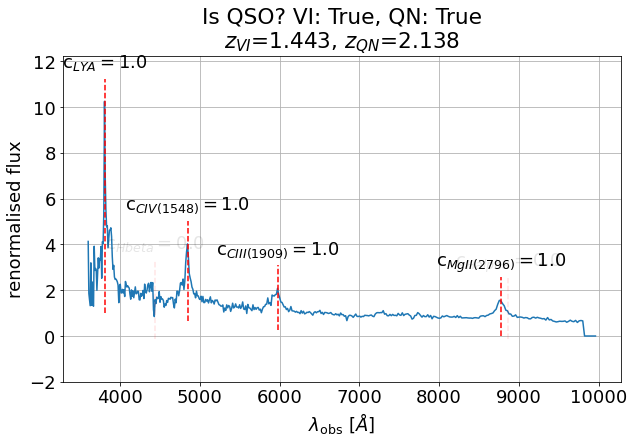

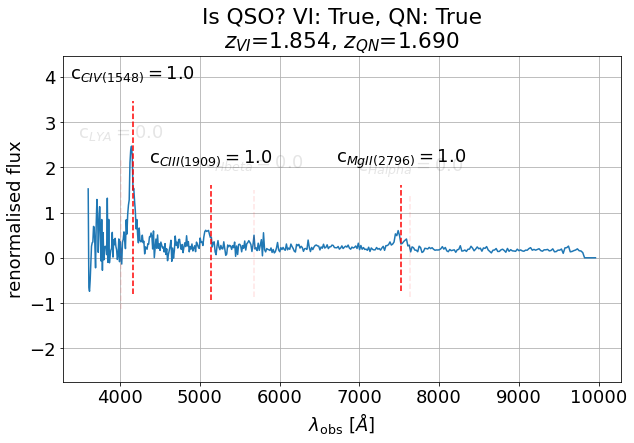

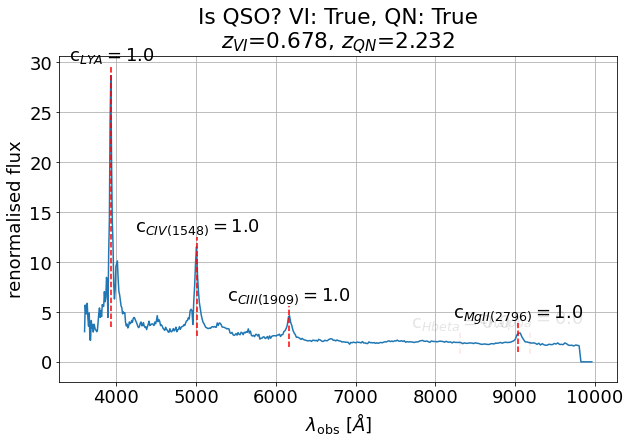

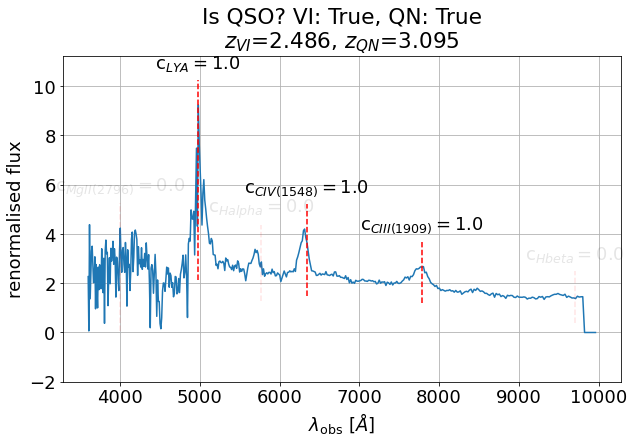

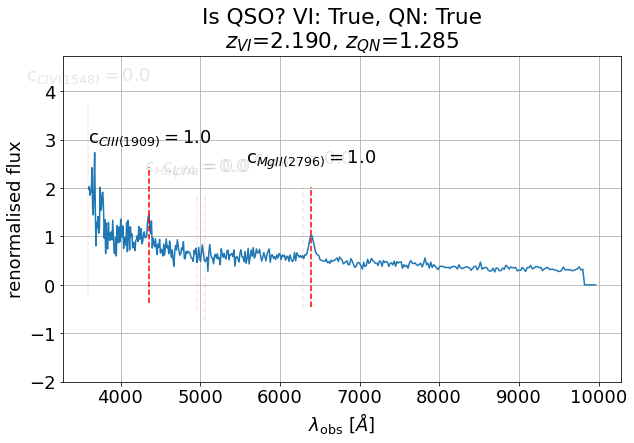

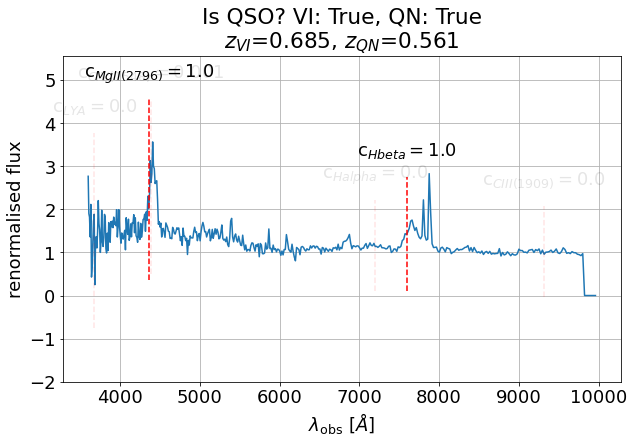

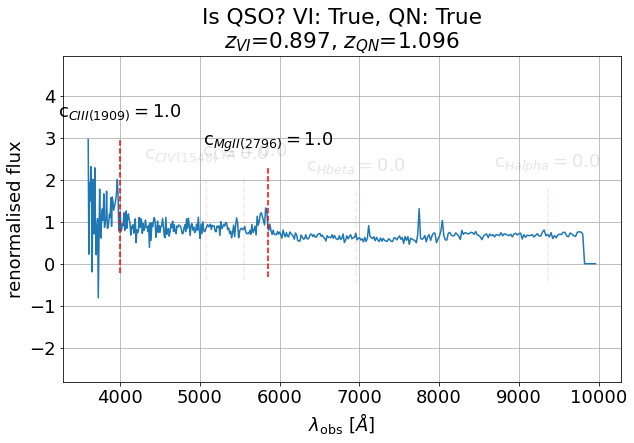

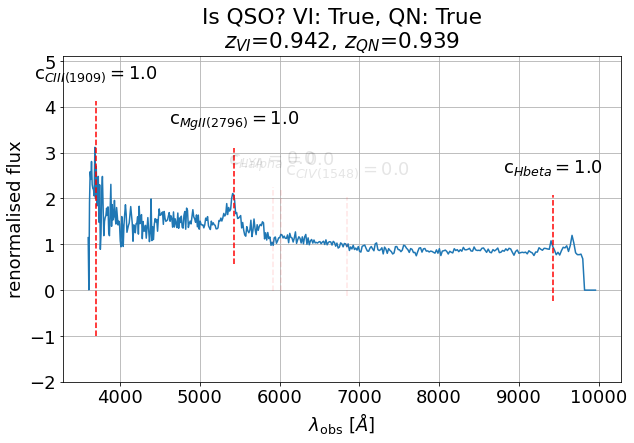

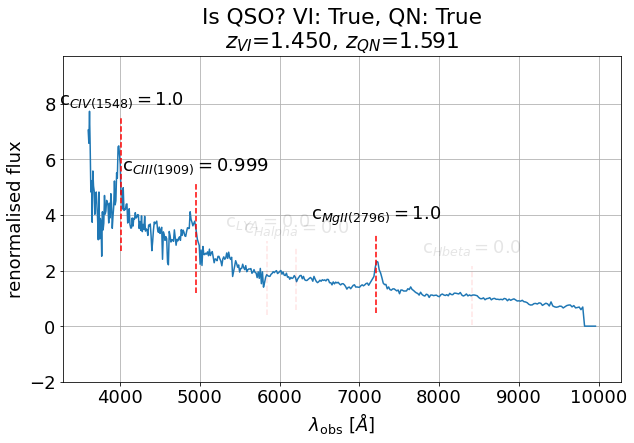

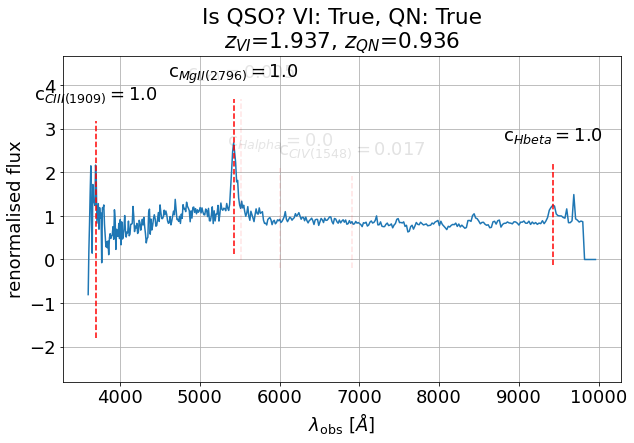

In [30]:
lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
ndetect = 1
c_th = 0.5

for num in range(10):
    plot_spectrum(num,Spectra,c_lines,z_lines,z_best,classification_VI,z_VI,c_th=c_th,ndetect=ndetect)

267 267


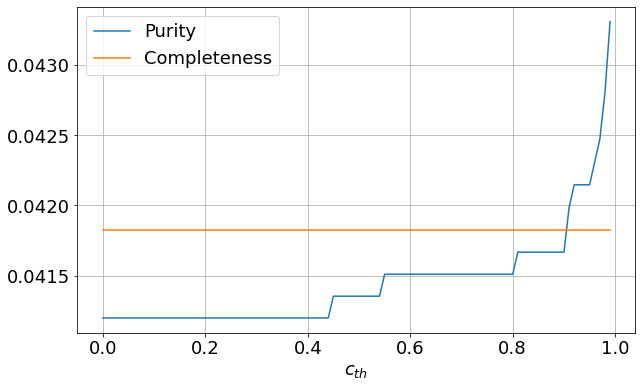

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

ndetect = 1

# Set up our arrays.
c_th = np.arange(0,1,0.01)
pur = c_th*0
com = c_th*0
dv_max = 6000./300000.

# Determine which objects are true QSOs, and which are "bad"
isqso_truth = (classification_VI.argmax(axis=1)==2) | (classification_VI.argmax(axis=1)==3)
is_bad = classification_VI.argmax(axis=1)==4

# Determine which spectra QN accurately estimated the redshift for
print(len(z_best),len(z_VI))
zgood = (z_VI>0) & (abs(z_best-z_VI) < dv_max*(1+z_VI))

# For each value of confidence threshold, compute purity and completeness.
for i,cth in enumerate(c_th):
    isqso_qn = (c_lines>cth).sum(axis=0)>=ndetect
    ntrue_positives = (isqso_qn & zgood & ~is_bad).sum()
    pur[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
    com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()
    
# Plot them!
ax.plot(c_th, pur, label='Purity')
ax.plot(c_th, com, label='Completeness')
#ax.set_xlim(0.0,1.0)
#ax.set_ylim(0.8,1.0)
ax.set_xlabel(r'$c_{th}$')
ax.grid()
ax.legend()